## 概要
slow neuron(prior)がある状態で学習したモデルとfast neuronのみで学習したモデルの精度を比較する

In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

### 環境の設定

環境はA→B→Cの順に切り替わる

In [2]:
state_list = [
    State(mu=0.5, sigma=0.4),
    State(mu=0, sigma=0.2),
    State(mu=-0.5, sigma=0.1),
]

In [3]:
# state_list = [
    # State(mu=-0.5, sigma=0.1),
    # State(mu=0.5, sigma=0.4),
    # State(mu=0, sigma=0.2),
# ]

In [4]:
def make_signal(N, time_length, state_list, uncertainty=0.5):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state_list[(t // 40) % 3]()
            true_signal_list[i, t] = true_signal
            # true_signal = state_list[2]()
            g = 2.5
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * 1 * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        # signal_mu_list.append(signal_mu)
        
    return input_signals, true_signal_list, signal_mu_list

### priorありのモデル

In [5]:
config_path = '../slow_reservoir/trained_model/dynamic_state/non_prior_2/non_prior_2.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_w_prior = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state/{model_name}/epoch_3000.pth'
model_w_prior.load_state_dict(torch.load(model_path, map_location=device))
model_w_prior.eval()



model_name:  non_prior_2


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

### priorなしのモデル

In [6]:
config_path = '../slow_reservoir/trained_model/dynamic_state/non_prior/non_prior.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_wo_prior = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state/{model_name}/epoch_3000.pth'
model_wo_prior.load_state_dict(torch.load(model_path, map_location=device))
model_wo_prior.eval()



model_name:  non_prior


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [7]:
sample_num = 1000
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=120, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))
             
# priorありのモデルによる推論
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_w_prior, prior_list = model_w_prior(inputs, hidden, reservoir, 120)                                                     
neural_dynamics_w_prior = hidden_list.cpu().detach().numpy()   

# priorなしのモデルによる推論
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_wo_prior, prior_list = model_wo_prior(inputs, hidden, reservoir, 120)                                                     
neural_dynamics_wo_prior = hidden_list.cpu().detach().numpy()   


### priorありのモデル

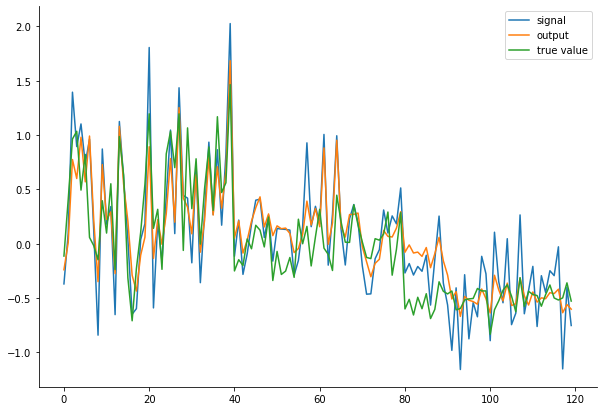

In [8]:
plt.figure(figsize=(10, 7))

plt.plot(signal_mu_list[0], label='signal')
plt.plot(outputs_w_prior[0, :, 0].tolist(), label='output')
plt.plot(true_signal_list[0], label='true value')

plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

### priorなしのモデル

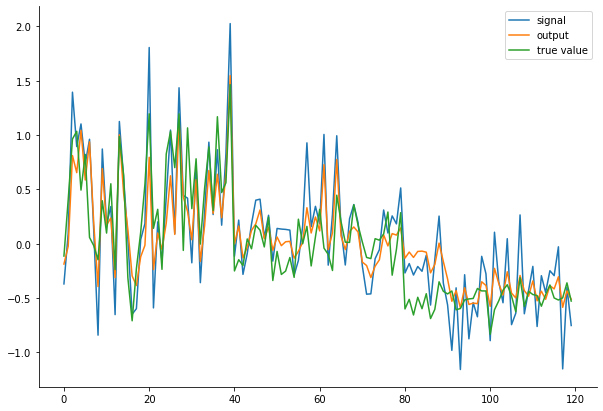

In [9]:
plt.figure(figsize=(10, 7))

plt.plot(signal_mu_list[0], label='signal')
plt.plot(outputs_wo_prior[0, :, 0].tolist(), label='output')
plt.plot(true_signal_list[0], label='true value')

plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.show()

## Mean Squared Lossの計測

In [10]:
mse_w_prior = mean_squared_error(
    np.array(outputs_w_prior[:, :, 0].tolist()),
    true_signal_list,
)
print(mse_w_prior)

0.04997598397803483


In [11]:
np.mean(np.var(np.array(outputs_w_prior[:, :, 0].tolist()), axis=1))

0.22166040074233015

In [12]:
np.mean(np.mean(np.array(outputs_w_prior[:, :, 0].tolist()), axis=1))

0.009950351262309897

In [13]:
mse_wo_prior = mean_squared_error(
    np.array(outputs_wo_prior[:, :, 0].tolist()),
    true_signal_list,
)
print(mse_wo_prior)

0.04900852205101085


In [14]:
np.mean(np.var(np.array(outputs_wo_prior[:, :, 0].tolist()), axis=1))

0.19249391283625034

In [15]:
np.mean(np.mean(np.array(outputs_wo_prior[:, :, 0].tolist()), axis=1))

-0.010556030735792593

## 結論
現状、non_prior modelの方が高精度...